In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Veri setini yükleme
df = pd.read_csv('data/year_2009_2010.csv',encoding='latin1')


In [8]:
# 1. Satış Analizi

# Toplam Satış Tutarı (Revenue)
df['TotalPrice'] = df['Quantity'] * df['Price']

# Zaman İçinde Satışların Dağılımı
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
monthly_sales = df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum()

# En Çok Satılan Ürünler
top_selling_products = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10)

In [12]:
# 2. Müşteri Segmentasyonu (RFM Analizi)

# RFM Metriği Hesaplama
latest_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
rfm_df = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'Invoice': 'count',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'Monetary'})


In [31]:


df = rfm_df

# RFM skorları hesaplayalım
df['R'] = pd.qcut(df['Recency'], 5, labels=range(5, 0, -1))
df['F'] = pd.qcut(df['Frequency'], 5, labels=range(1, 6))
df['M'] = pd.qcut(df['Monetary'], 5, labels=range(1, 6))

# RFM Segmentini belirleyelim
df['RFM_Segment'] = df['R'].astype(str) + df['F'].astype(str) + df['M'].astype(str)

# Segmentlere ayıralım
seg_map = {
    r'[1-2][1-2][1-2]': 'Hibernating',
    r'[3-4][1-2][1-2]': 'At Risk',
    r'[4-5][4-5][4-5]': 'Champions',
    r'[3-4][3-4][3-4]': 'Loyal Customers',
    r'[1-2][4-5][4-5]': 'New Customers'
}

# Segmentleri belirleyelim ve OTHERS olarak gruplayalım
df['Segment'] = df['RFM_Segment'].replace(seg_map, regex=True)
df['Segment'] = df['Segment'].apply(lambda x: x if x in seg_map.values() else 'Others')

print(df)


             Recency  Frequency  Monetary  R  F  M RFM_Segment        Segment
Customer ID                                                                  
12346.0           67         46    -64.68  3  3  1         331         Others
12347.0            3         71   1323.32  5  4  4         544      Champions
12348.0           74         20    222.16  2  2  1         221    Hibernating
12349.0           43        107   2646.99  3  4  5         345         Others
12351.0           11         21    300.93  5  2  2         522         Others
...              ...        ...       ... .. .. ..         ...            ...
18283.0           18        230    641.77  4  5  3         453         Others
18284.0           65         29    436.68  3  2  2         322        At Risk
18285.0          296         12    427.00  1  1  2         112    Hibernating
18286.0          112         70   1188.43  2  4  4         244  New Customers
18287.0           18         86   2340.61  4  4  5         445  

In [32]:
# Benzersiz segmentleri ve bu segmentlerdeki müşteri sayılarını gruplamak
segment_counts = df.groupby('Segment').size().reset_index(name='Customer_Count')

print(segment_counts)

           Segment  Customer_Count
0          At Risk             430
1        Champions             922
2      Hibernating             883
3  Loyal Customers             428
4    New Customers             215
5           Others            1505


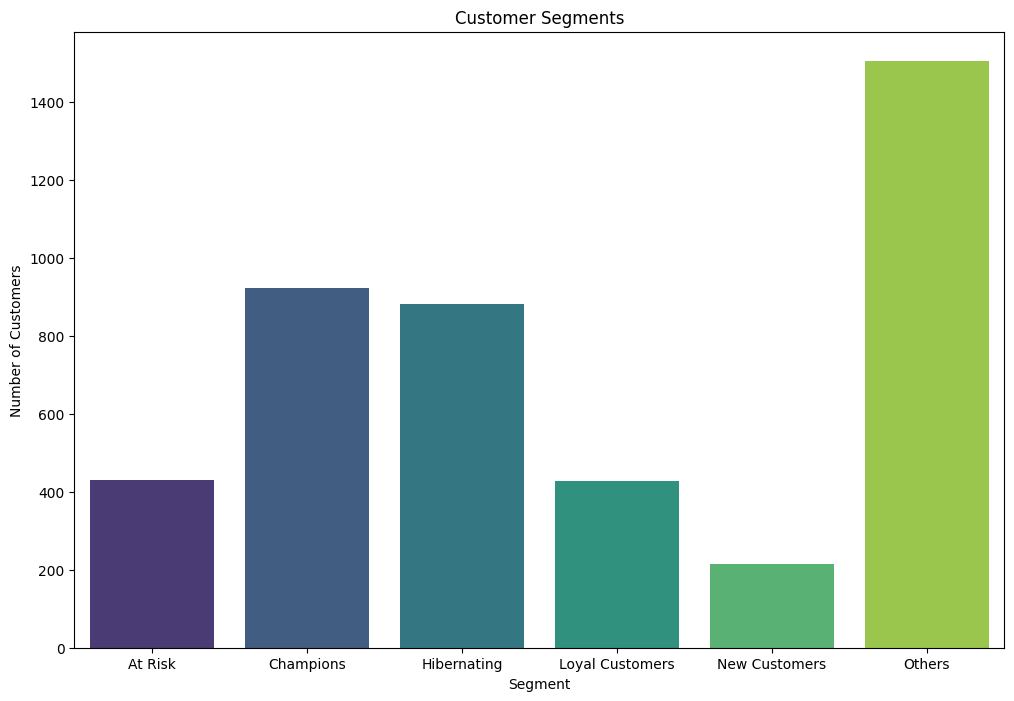

In [39]:
# Segment dağılımını görselleştirelim
plt.figure(figsize=(12,8))
sns.barplot(x='Segment', y='Customer_Count', data=segment_counts, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()